In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

We've seen classification of text over the last few lessons. But what about if we want to generate new text. Now this might sound like new unbroken ground, but when you think about it, you've actually covered everything that you need to do this already. Instead of generating new text, how about thinking about it as a prediction problem. Remember when for example you had a bunch of pixels for a picture, and you trained a neural network to classify what those pixels were, and it would predict the contents of the image, like maybe a fashion item, or a piece of handwriting. Well, text prediction is very similar. We can get a body of texts, extract the full vocabulary from it, and then create datasets from that, where we make it phrase the Xs and the next word in that phrase to be the Ys. For example, consider the phrase, Twinkle, Twinkle, Little, Star. What if we were to create training data where the Xs are Twinkle, Twinkle, Little, and the Y is star. Then, whenever neural network sees the words Twinkle, Twinkle, Little, the predicted next word would be star. Thus given enough words in a corpus with a neural network trained on each of the phrases in that corpus, and the predicted next word, we can come up with some pretty sophisticated text generation.

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [3]:
tokenizer = Tokenizer()

# this is an example of text. The entire song is contained into a single string
data="In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."

# caling split we can create a python list of sentences
corpus = data.lower().split("\n")

# fit the tokenizer and create a dictionary of words/tokens
# key/value pair with the key being the word and the value the token
tokenizer.fit_on_texts(corpus)
# total number of words in dictionary +1 for oov words
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)


{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

So now, we have to split our sequences into our x's and our y's. To do this, let's grab the first n tokens, and make them our x's. We'll then get the last token and make it our label. Before the label becomes a y, there's one more step, and you'll see that shortly. Python makes this really easy to do with it's less syntax.
So to get my x's, I just get all of the input sequences sliced to remove the last token. To get the labels, I get all of the input sequence sliced to keep the last token. Now, I should one-hot encode my labels as this really is a classification problem. Where given a sequence of words, I can classify from the corpus, what the next word would likely be. So to one-hot encode, I can use the contrast utility to convert a list to a categorical. I simply give it the list of labels and the number of classes which is my number of words, and it will create a one-hot encoding of the labels. 

In [4]:
input_sequences = []

for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
# one hot encode, list of labels and number of clases wich is the number of words
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [5]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

4
2
66
8
67
68
69
70


In [6]:
print(xs[6])

[ 0  0  0  4  2 66  8 67 68 69]


In [7]:
print(ys[6])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
print(xs[5])
print(ys[5])

[ 0  0  0  0  4  2 66  8 67 68]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
print(tokenizer.word_index)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [ ]:
  # lot of epochs cause very few data
  model = Sequential()
  model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
  model.add(Bidirectional(LSTM(20)))
  model.add(Dense(total_words, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(xs, ys, epochs=500, verbose=1)


In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

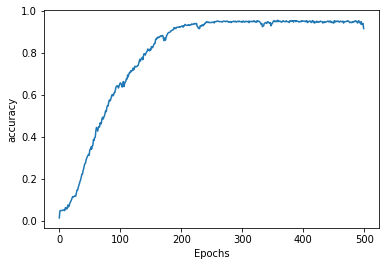

In [12]:
plot_graphs(history, 'accuracy')


So if I seeded with this text Lawrence went to Dublin, I am going to ask it for the next 100 words. What it's going to do, is for each of the next 100 words it's going to create a token lists using tokenizer text sequences of the seed text. Then that token list is going to get padded to the actual length that we want. Then that's going to be passed into the model. So we're going to predict the classes for the token list that was generated off of this seed text and then we'll get an output word from that. Then that will be used to feed into the next time round to predict again to get another model. So when we start with Lawrence went to Dublin, it'll get us another word and that phrase will generate another word and that phrase will generate another word etc.


In [13]:
seed_text = "Laurence went to dublin"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Laurence went to dublin til saw got a phelim mchugh mchugh mchugh he fall fainted mavrone away mavrone entangled mad at me mavrone a kerrigan fainted a fainted mavrone me mavrone entangled mavrone dublin relations hall fainted entangled around hearty creature rose fainted and fainted entangled and fainted and red and and girls hearty were hearty hearty might fainted entangled up entangled entangled entangled punch mavrone entangled entangled hall hall hall eyes glisten hearty he fall fainted mavrone entangled me mavrone mavrone entangled mavrone entangled fainted entangled entangled round polkas punch til hall hall fainted me mavrone mavrone entangled me mav

So if I print that out, we'll get something like this. Lawrence went to Dublin a twist of a reel and a jig, jig gathered gathered them long new weeks i spent up jig Dublin might ask ask ask mother asks jig man again. We can see what's actually happening here is that in the beginning it kind of looks pretty good. It's beginning to make sense. But of course because our body of texts is pretty small and each prediction is a probability. So after the words Lawrence went to Dublin, the most probable word that would come next is A, but of course it's not 100 percent certainty. It's a probability and then the probability of the next probable word after Lawrence went to Dublin A would be twist and keep going twist over reel and a jig. But as you can see then, as you get further and further and further then the probabilities are decreasing and the quality of the prediction as a result goes down. So you end up with for example repeated words like Jake Jake, gathered gathered. It's kind of fun if we take a look at some of the words in the song, so we could see how they would deal with the prediction. So for example, when we say Lawrence went to Dublin, a twist of a reel. So let's take a look at a twist of a reel. If we go back to the original song and the text of the original song see if those words actually exist.